# Agrupamento de Imagens

A técnica de agrupamento consiste em *rotular* elementos de um conjunto de dados inicialmente não-rotulados com base na semelhança existente entre esses elementos. A ideia é que elementos que possuem características semelhantes devem pertencer a um mesmo tipo.

No mundo real, a maior quantidade de dados existentes não possuem rótulos prévios. Dessa maneira, aprender como funcionam os algoritmos de agrupamento é vital para conseguir tratar problemas complexos.

Neste notebook, vamos somente demonstrar o que seria o agrupamento com base nas características intrínsecas de imagens: suas cores. O objetivo é separar em grupos os objetos (simples círculos de cores diferentes) que estão dentro de uma mesma imagem.

Vamos utilizar o algoritmo mais conhecido e, ao mesmo tempo, mais simples para fazer o agrupamento: o *k*-means. Esse algoritmo é particional, baseado em distância e iterativo. Ele agrupa os dados em torno de pontos concentradores de dados (os centróides). Mais informações sobre o algoritmo podem ser encontradas [aqui](https://en.wikipedia.org/wiki/K-means_clustering).

Para realizar o agrupamento, vamos fazer uso do pacote `KMeans` do `sklearn.cluster`.

## Criando um cenário

Vamos construir uma imagem composta de diversos círculos com cores diferentes. Essa imagem pode representar, por exemplo, uma placa com reagentes e o objetivo é filtrar os tipos de reação com base na cor desses reagentes. Nesse caso, os reagentes são representados (coincidentemente) pelas cores vermelho, verde e azul.

In [ ]:
# importando pacotes
from sklearn.cluster import KMeans
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow

import imutils

# lista de cores
colors = [
	# shades of red, green, and blue
	(138, 8, 8), (180, 4, 4), (223, 1, 1), (255, 0, 0), (250, 88, 88),
	(8, 138, 8), (4, 180, 4), (1, 223, 1), (0, 255, 0), (46, 254, 46),
	(11, 11, 97), (8, 8, 138), (4, 4, 180), (0, 0, 255), (46, 46, 254)]
#  canvas
canvas = np.ones((400, 600, 3), dtype="uint8") * 255
# loop no canvas
for y in range(0, 400, 20):
	for x in range(0, 600, 20):
		# gera coordenada aleatoria (x, y), raio, e cor para o circulo
		(dX, dY) = np.random.randint(5, 10, size=(2,))
		r = np.random.randint(5, 8)
		color = random.choice(colors)[::-1]
		# desenha o circulo
		cv2.circle(canvas, (x + dX, y + dY), r, color, -1)
# cria uma borda no canvas
canvas = cv2.copyMakeBorder(canvas, 5, 5, 5, 5, cv2.BORDER_CONSTANT,
	value=(255, 255, 255))

Ao final desse processo, temos a seguinte imagem para tratar.

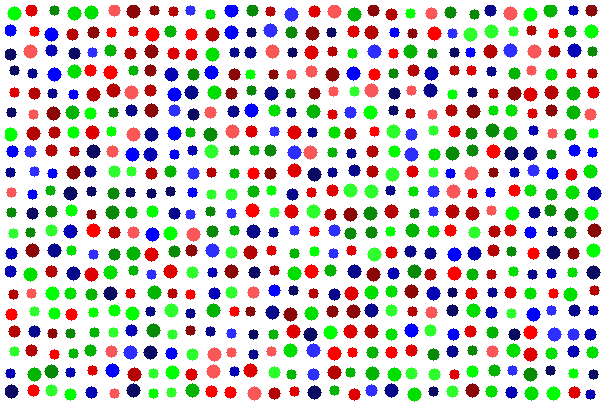

In [ ]:
cv2_imshow(canvas)

## Destacando os objetos

Uma vez de posse da imagem contendo os objetos coloridos, devemos conseguir capturar individualmente cada um deles. Para isso, vamos utilizar dois procedimentos básicos:

- *thresholding*: binarizar a imagem e separar o fundo do objeto de interesse.
- extrair contornos: devemos detectar os contornos para poder extrair cada um dos objetos.

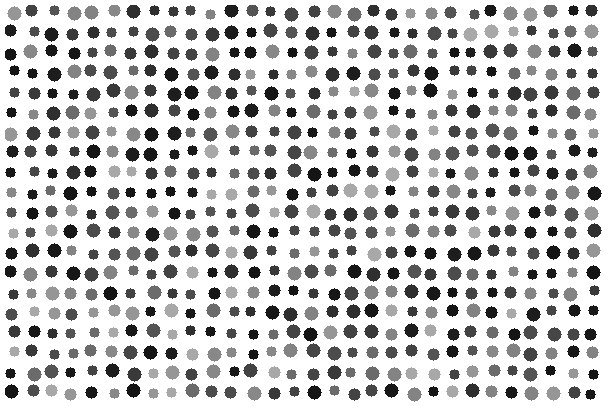

In [ ]:
# converte a imagem para escala de cinza para facilitar a binarização
gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

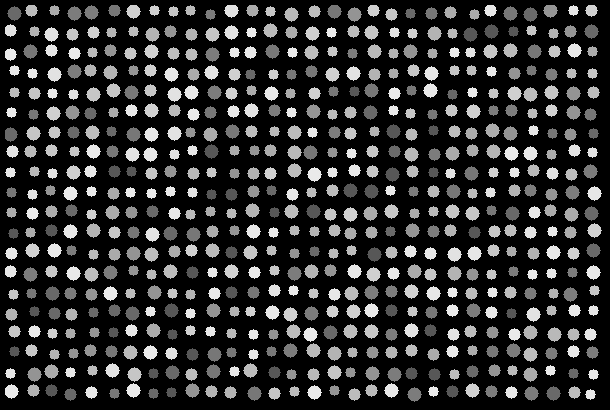

In [ ]:
# inverte os bits da imagem para destacar os objetos de frente e deixar o fundo preto.
gray = cv2.bitwise_not(gray)
cv2_imshow(gray)

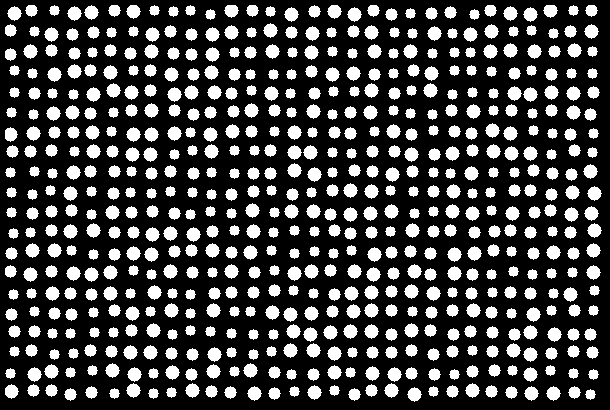

In [ ]:
# aplica a binarização para deixar
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
cv2_imshow(thresh)

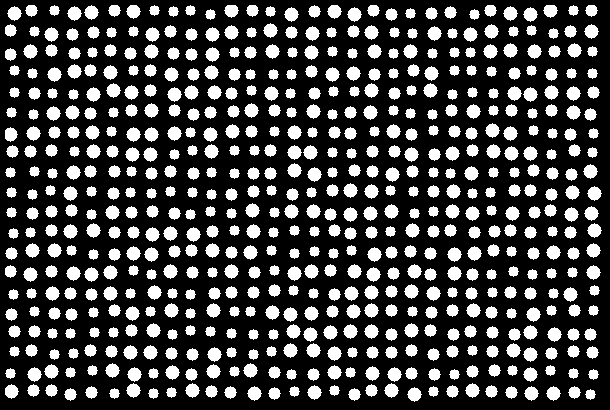

In [ ]:
# extrai os contornos dos objetos da imagem.
cnts = cv2.findContours(gray.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# novo canvas só para exibir contornos
canvas_tmp = np.ones((400, 600), dtype="uint8") * 0
canvas_tmp = cv2.copyMakeBorder(canvas_tmp, 5, 5, 5, 5, cv2.BORDER_CONSTANT,
	value=(0,0,0))

# loop por todos os contornos.
for c in cnts:
  # cria mascara a partir dos contornos
  mask = np.zeros(canvas_tmp.shape[:2], dtype="uint8")
  # desenha contornos
  cv2.drawContours(mask, [c], -1, 255, -1)
  # adiciona contorno no canvas
  canvas_tmp = cv2.bitwise_or(canvas_tmp, mask)

# mostra os contornos extraídos da imagem
cv2_imshow(canvas_tmp)

In [ ]:
# cria a base de dados a partir do valor médio de RGB dos pixels da imagem original
# que estão destacados por cada contorno extraído.

# array para armazenar dados
data = []

# loop por todos os contornos
for c in cnts:
  # cria canva a ser utilizado como máscara 
  mask = np.zeros(canvas.shape[:2], dtype="uint8")
  # desenha contornos na máscara
  cv2.drawContours(mask, [c], -1, 255, -1)
  # extrai as features do objeto (valor médio de RGB)
  features = cv2.mean(canvas, mask=mask)[:3]
  # adiciona as features ao array de dados
  data.append(features)

In [ ]:
# exemplo de uma entrada da base de dados
print(data[0])

# número de entradas na base de dados
print(len(data))

(180.0, 4.0, 4.0)
600


## Agrupando

Com a base de dados formada, temos que realizar o agrupamento das instâncias (entradas) presentes nela. Cada uma dessas entradas corresponde ao um círculo detectado na imagem.

Vamos utilizar o algoritmo *k-means* para isso. A função já foi importada no início do notebook e ela é a `KMeans()`.

Vale salientar que o algoritmo *k-means* tem como parâmetro obrigatório, o número de grupos desejado. A quantidade de grupos depende muito da necessidade do problema. Nesse caso, como sabemos os tipos de reagentes (problema hipotético) que temos e o que queremos é, na verdade, filtrar os pontos da imagem que são dessas cores. Assim, o número de grupos definido vai ser igual a três.

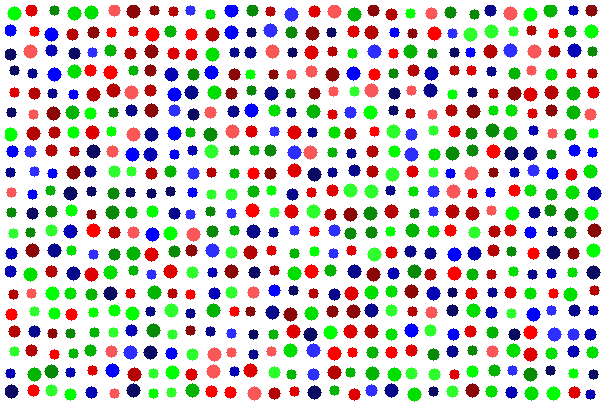

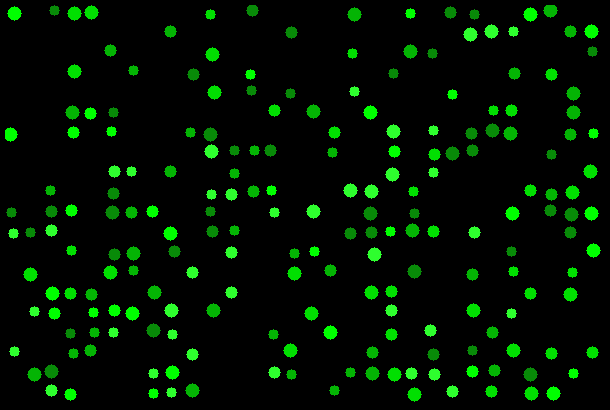

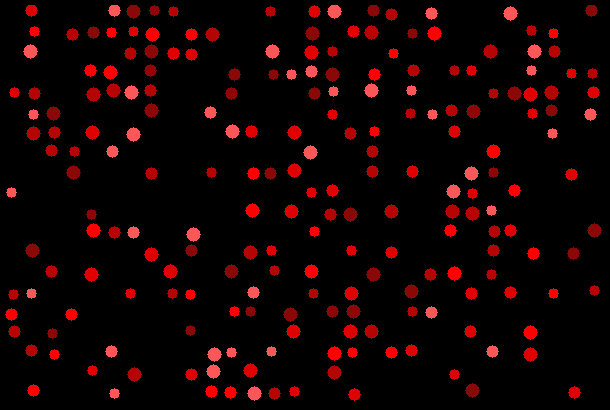

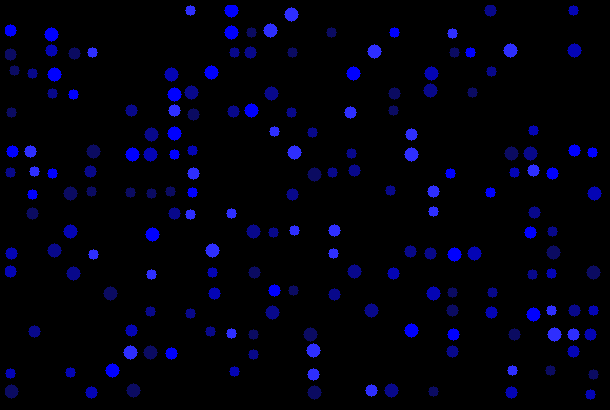

In [ ]:
# inicializa o k-means com três grupos
clt = KMeans(n_clusters=3)
# agrupa a partir das caracteristicas extraídas (cores)
clt.fit(data)
# mostra a imagem inicial para comparação
cv2_imshow(canvas)
# loop pelos grupos encontrados pelo k-means
for i in np.unique(clt.labels_):
	# cria a mascara do grupo atual
	mask = np.zeros(canvas.shape[:2], dtype="uint8")
	# loop nos objetos do cluster para desenhar cada um deles
	for j in np.where(clt.labels_ == i)[0]:
		cv2.drawContours(mask, [cnts[j]], -1, 255, -1)
	# mostra a imagem final
	cv2_imshow(cv2.bitwise_and(canvas, canvas, mask=mask))

Imagine que somente os valores que possuem uma determinada saturação são considerados válidos para um determinado reagente. Nesse caso, podemos filtrar os elementos que ultrapassam esse limiar. 

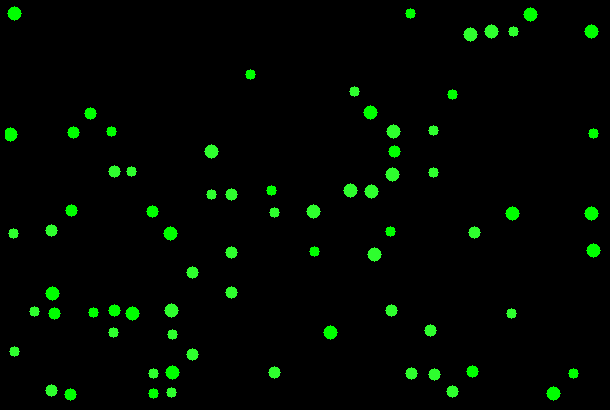

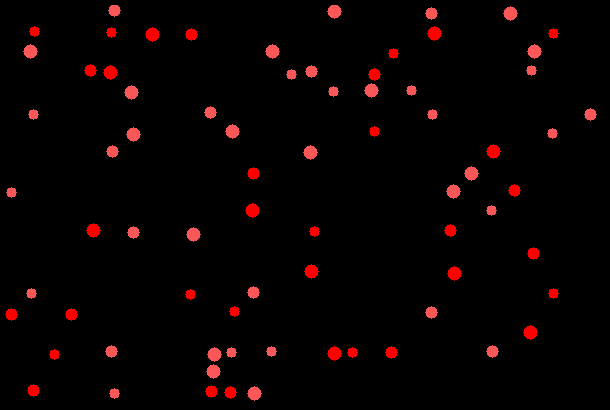

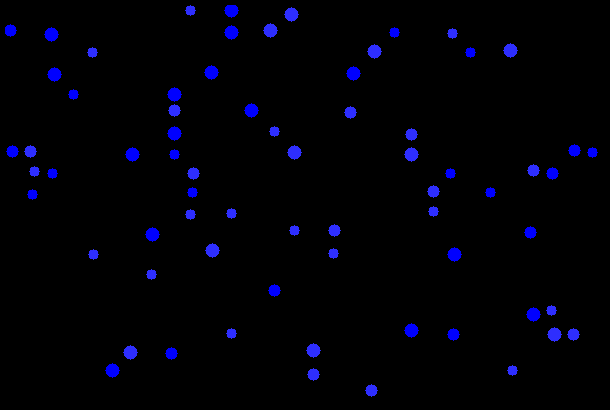

In [ ]:
for i in np.unique(clt.labels_):
  # cria a mascara do grupo atual
  mask = np.zeros(canvas.shape[:2], dtype="uint8")
  # loop nos objetos do cluster para desenhar cada um deles
  for j in np.where(clt.labels_ == i)[0]:
    # filtra elementos que não possuem cor principal maior que 240
    if max(data[j]) > 240:
      cv2.drawContours(mask, [cnts[j]], -1, 255, -1)
  # mostra a imagem final
  cv2_imshow(cv2.bitwise_and(canvas, canvas, mask=mask))

# Agrupamento cenários

In [ ]:
# importando os pacotes necessários
import cv2
import os
from sklearn.cluster import KMeans
import numpy as np
import random
from google.colab.patches import cv2_imshow


## Baixando a base de dados

In [ ]:
# baixando o conjunto de dados
!rm *.zip
!rm *.zip.*
!rm -r 4scenes
!wget 'https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/4scenes.zip'
!ls -l

rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.zip.*': No such file or directory
rm: cannot remove '4scenes': No such file or directory
--2022-02-02 17:16:09--  https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/4scenes.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/4scenes.zip [following]
--2022-02-02 17:16:09--  https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/4scenes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54187202 (52M) [a

In [ ]:
# descompactando o conjunto de dados
!unzip '/content/4scenes.zip'

Archive:  /content/4scenes.zip
   creating: 4scenes/
  inflating: 4scenes/highway_gre141.jpg  
  inflating: 4scenes/highway_bost389.jpg  
  inflating: 4scenes/highway_gre155.jpg  
  inflating: 4scenes/coast_natu641.jpg  
  inflating: 4scenes/forest_land314.jpg  
  inflating: 4scenes/street_street61.jpg  
  inflating: 4scenes/forest_nat449.jpg  
  inflating: 4scenes/forest_cdmc451.jpg  
  inflating: 4scenes/street_hexp29.jpg  
  inflating: 4scenes/highway_bost148.jpg  
  inflating: 4scenes/forest_land102.jpg  
  inflating: 4scenes/highway_bost160.jpg  
  inflating: 4scenes/highway_bost174.jpg  
  inflating: 4scenes/coast_n203030.jpg  
  inflating: 4scenes/street_bost50.jpg  
  inflating: 4scenes/forest_nat717.jpg  
  inflating: 4scenes/forest_cdmc280.jpg  
  inflating: 4scenes/street_bost137.jpg  
  inflating: 4scenes/highway_urb710.jpg  
  inflating: 4scenes/forest_natu308.jpg  
  inflating: 4scenes/coast_land113.jpg  
  inflating: 4scenes/coast_natu912.jpg  
  inflating: 4scenes/stree

Tamanho da imagem: (256, 256, 3)


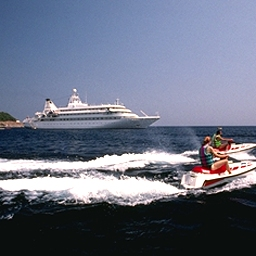

In [ ]:
sample_image = cv2.imread('4scenes/coast_arnat59.jpg')
print(f'Tamanho da imagem: {sample_image.shape}')
cv2_imshow(sample_image)

## Extranindo características

Como vamos extrair os histogramas das imagens para utilizaer como características da nossa base de dados, uma passo importante é a conversão do espaço de cores.

No espaço Lab, a distância euclidiana entre duas cores possuem significado. Dessa maneira, como estamos utilizando o *k-means* como algoritmo de agrupamento e ele também vai utilizar a distância euclidiana, faz bastante sentido realizar essa conversão.

In [ ]:
def describe2(image, mask=None):
  # define o tamanho dos bins
  bins = [8, 8, 8]
  # converte a imagem para o espaço L*a*b* 
  #lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  # computa o histograma
  hist = cv2.calcHist([image], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
  # normaliza o histograma
  hist = cv2.normalize(hist,hist).flatten()
  # return the histogram
  return hist

In [ ]:
def describe(image, mask=None):
  # define o tamanho dos bins
  bins = [16, 16, 16]
  # converte a imagem para o espaço L*a*b* 
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  # computa o histograma
  hist = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
  # normaliza o histograma
  hist = cv2.normalize(hist,hist).flatten()
  # return the histogram
  return hist

É muito importante realizar esse último passo de normalização do histograma. Caso contrário, imagens com o mesmo conteúdo, mas de tamanhos diferentes vão ter histogramas completamente diferentes. Com isso, a largura e altura da imagem não exerce influência na extração dos histogramas.

In [ ]:
imagesPath = './4scenes'
labels = []
data = []
images = []

files = os.listdir(imagesPath)

print("[INFO] extraindo features...")

# loop em todas as imagens do diretório
for image_name in files:
  # extraindo o rótulo das imagens (primeira parte do nome do arquivo)
  label = image_name[image_name.rfind("/") + 1:].split("_")[0]
  # carregando a imagem
  image = cv2.imread(imagesPath+'/'+image_name)  
  # extraindo as features da imagem
  features = describe2(image)
  # adicionando o rótulo da imagem (classe) em uma lista de rótulos
  labels.append(label)
  # adicionando a imagem (features) ao conjunto de dados
  data.append(features)
  # armazenando as imagens
  images.append(image)

[INFO] extraindo features...


## Agrupando

Vamos utilizar o algoritmo *k-means* para realizar o agrupamento. Nesse caso, queremos dividir o conjunto de imagens em quatro possíveis cenários diferentes.

In [ ]:
# agrupa os dados de histograma de cores
clt = KMeans(n_clusters=2)
labels = clt.fit_predict(data)

In [ ]:
def print_labeled_images(labels):
  num_samples = 10
  size = 70
  # loop por cada grupo para exibir imagens deles
  for i in np.unique(labels):
    # extrai os indices dos objetos com o label atual
    labels_ = np.where(labels == i)[0]
    # sorteia 3 índices aleatórios do conjunto de rótulos atual
    rand_samples = np.random.randint(0,len(labels_),size=(num_samples,1))
    # cria canvas vazio para incluir as imagens
    #img_conc = np.zeros((256, 256, 3), dtype="uint8")
    img_total = np.zeros((size,size*num_samples,3), dtype="uint8")
    k = 0
    for j in rand_samples:
      image = images[j[0]]
      #img_conc = np.concatenate((img_conc,image),axis=1)
      resized = cv2.resize(image, (size,size), interpolation = cv2.INTER_AREA)
      img_total[:,size*k:size*k+size,:] = resized
      k += 1
    print(f'imagens do grupo {i}')
    cv2_imshow(img_total)


imagens do grupo 0


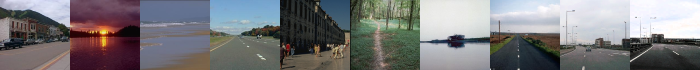

imagens do grupo 1


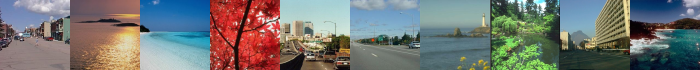

In [ ]:
print_labeled_images(labels)

imagens do grupo 0


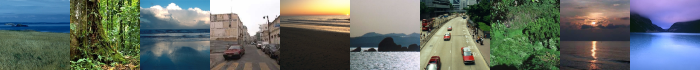

imagens do grupo 1


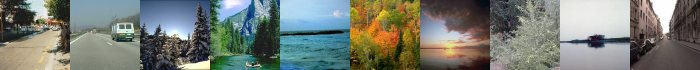

imagens do grupo 2


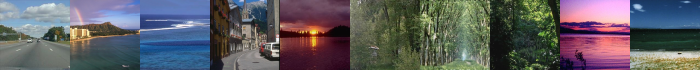

In [ ]:
clt = KMeans(n_clusters=3)
labels = clt.fit_predict(data)
print_labeled_images(labels)

imagens do grupo 0


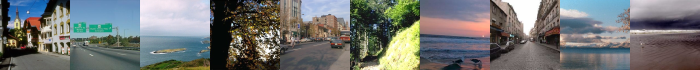

imagens do grupo 1


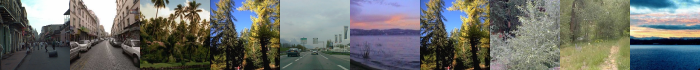

imagens do grupo 2


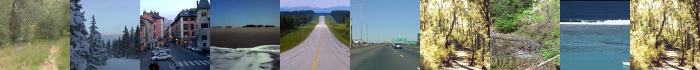

imagens do grupo 3


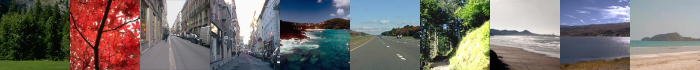

In [ ]:
clt = KMeans(n_clusters=4)
labels = clt.fit_predict(data)
print_labeled_images(labels)

imagens do grupo 0


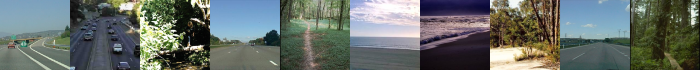

imagens do grupo 1


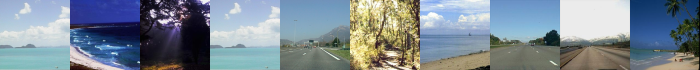

imagens do grupo 2


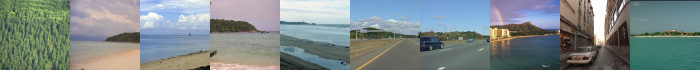

imagens do grupo 3


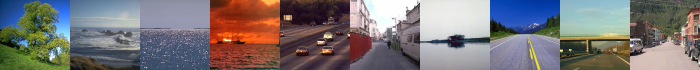

imagens do grupo 4


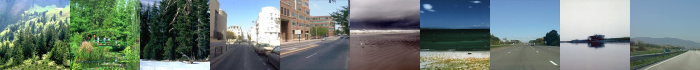

In [ ]:
clt = KMeans(n_clusters=5)
labels = clt.fit_predict(data)
print_labeled_images(labels)

imagens do grupo 0


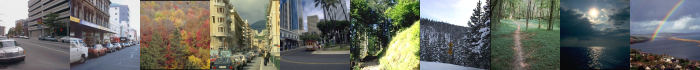

imagens do grupo 1


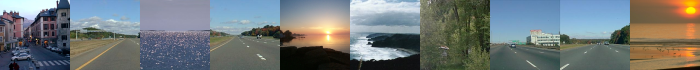

imagens do grupo 2


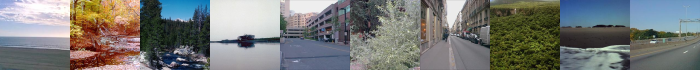

imagens do grupo 3


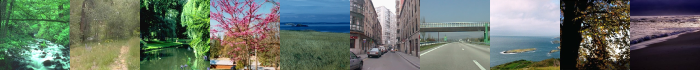

imagens do grupo 4


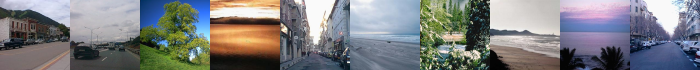

imagens do grupo 5


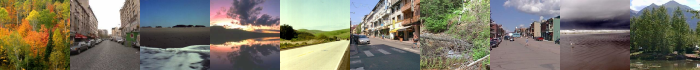

In [ ]:
clt = KMeans(n_clusters=6)
labels = clt.fit_predict(data)
print_labeled_images(labels)

Quando não conseguimos definir o número de grupos a partir de uma análise inicial, devemos recorrer a uma estratégia de avaliação do agrupamento. Para isso, costumeiramente, executamos o algoritmo com variados números de grupos e calculamos a qualidade da partição gerada a partir de um índice.

O índice mais básico é a própria variação intra-cluster dos grupos gerados pelo *k-means*. 

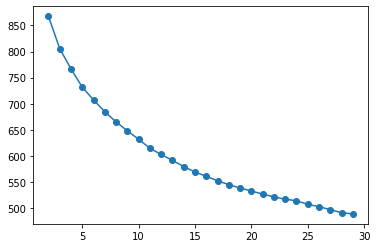

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# intervalo de valores para o número de grupos
ks = range(2, 30)
# lista para armazenar todos os valores de índice de cada agrupamento
inertias = []
for k in ks:    
    km = KMeans(n_clusters=k, random_state=8)
    km.fit(data)
    # calcula a inertia, ou a variação intra-cluster do agrupamento
    inertias.append(km.inertia_)

# plota o valor dos índices com relação ao número de grupos.    
plt.plot(ks, inertias, marker='o')

Por ser uma medida de variância intra-cluster, é normal que os valores sejam descrescentes. No entanto, é esperado alguma mudança brusca de valores, o que indicaria uma disposição de grupos mais adequada.

Quando isso não acontece, recorremos a outras medidas. Uma delas é a [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)), que verifica a semelhança dos objetos dentro de um grupo comparada com a semalhança dos objetos com outros grupos.

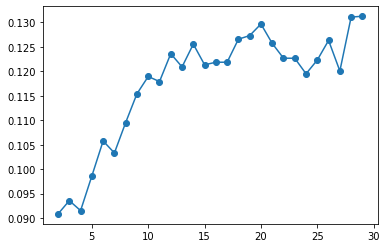

In [ ]:
from sklearn.metrics import silhouette_score

clt = KMeans(n_clusters=5)
labels = clt.fit_predict(data)

ks = range(2, 30)
silhouettes = []
for k in ks:    
    clt = KMeans(n_clusters=k, random_state=8)
    labels = clt.fit_predict(data)
    s = silhouette_score(data,labels)
    silhouettes.append(s)
    
plt.plot(ks, silhouettes, marker='o')

O valor da sihouette varia entre -1 e 1 e valores próximos a 1 são melhores enquanto que valores negativos indicam a colocação de elementos em grupos errados. Valores próximos a zero indicam sobreposição de grupos.

Nesse caso, os agrupamentos com 4, 5 e 15 grupos obtiveram os melhores valores. Vamos plotar abaixo essas configurações.

In [ ]:
clt = KMeans(n_clusters=20)
labels = clt.fit_predict(data)
print_labeled_images(labels)

Output hidden; open in https://colab.research.google.com to view.

imagens do grupo 0


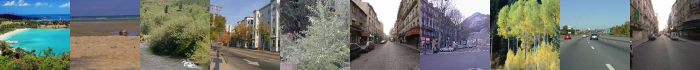

imagens do grupo 1


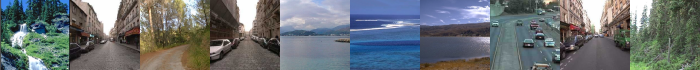

imagens do grupo 2


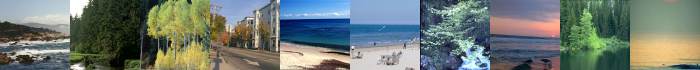

imagens do grupo 3


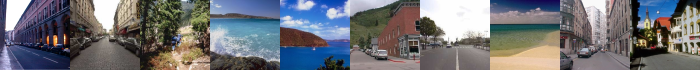

imagens do grupo 4


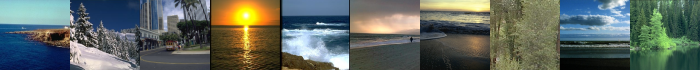

In [ ]:
clt = KMeans(n_clusters=5)
labels = clt.fit_predict(data)
print_labeled_images(labels)

imagens do grupo 0


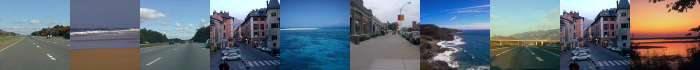

imagens do grupo 1


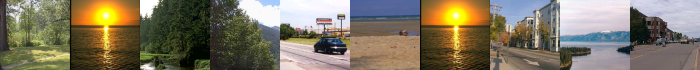

imagens do grupo 2


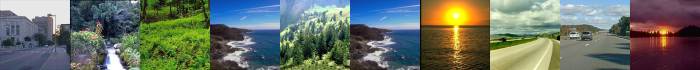

imagens do grupo 3


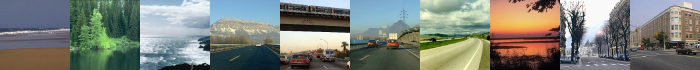

imagens do grupo 4


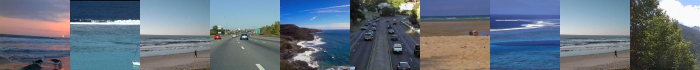

imagens do grupo 5


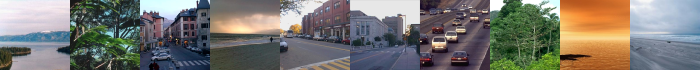

imagens do grupo 6


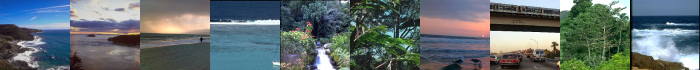

imagens do grupo 7


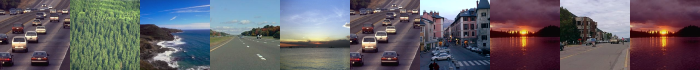

imagens do grupo 8


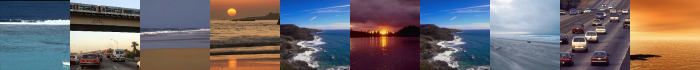

imagens do grupo 9


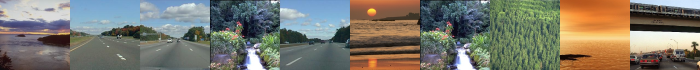

imagens do grupo 10


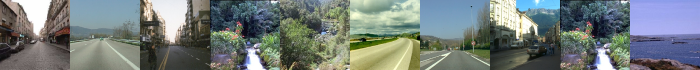

imagens do grupo 11


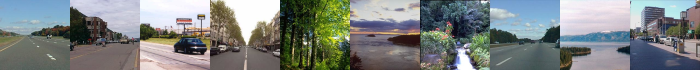

imagens do grupo 12


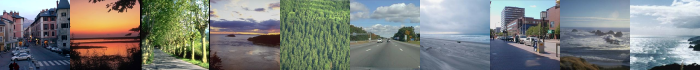

imagens do grupo 13


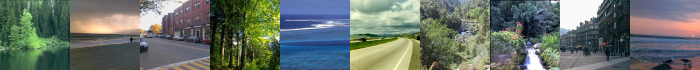

imagens do grupo 14


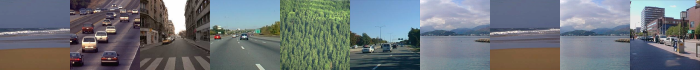

imagens do grupo 15


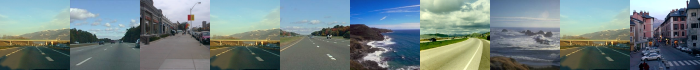

imagens do grupo 16


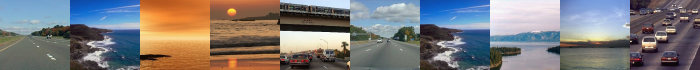

imagens do grupo 17


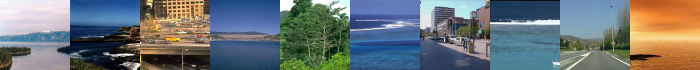

imagens do grupo 18


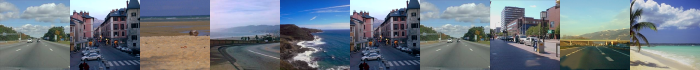

imagens do grupo 19


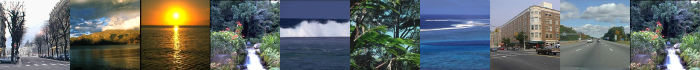

In [ ]:
clt = KMeans(n_clusters=20)
labels = clt.fit_predict(data)
print_labeled_images(labels)

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# CIFAR10
